<a href="https://colab.research.google.com/github/tinahuang222/NucleiSegmentation/blob/master/PREPROCESSING/Aggregate_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

from PIL import Image  

import json
import pandas as pd

import csv

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import pickle

#specific versions required for downloaded code segments
#!pip3 install -q scipy==1.2.0
#!pip3 install -q imgaug==0.2.6


################################################################################
# Read Data from google drive
################################################################################
from google.colab import drive #for loading gdrive data
drive.mount('/content/gdrive')

###                     MAIN DIRECTORY NAMES
gdir = '/content/gdrive/My Drive/'
main_directory = gdir

#
#directory of top level of user data
#
feature_folder = os.path.join(gdir,'FEATURE_EXTRACTION')
tile_label_dir = os.path.join(gdir,feature_folder,'tiles_rois')




use_pickle = 1  #use pre-saved pickle data insted of reprocessing data
use_cdata_pickle = 1 #store intermediate cdata data from csv
use_output_pickle = 1


#directory to CSV files from Tina. This contains mask1 and mask2 zip data
features_dir = os.path.join(gdir,'TILE_PREPROCESSING',
                                   'Feature_extractions_unzipped_merge')

linreg_dir = os.path.join(gdir,'TILE_PREPROCESSING','PLOTS','LINREG')



#
#pickle file used to store full image sets, which take more than a minute to run
#
pickle_dir = os.path.join(main_directory, 'TILE_PREPROCESSING')
pickle_file = os.path.join(pickle_dir,'PICKLE_FEATURES_REMAPPED.pck')
pickle_output_file = os.path.join(pickle_dir,'PICKLE_FEATURES_AVERAGE_OUTPUT.pck')
pickle_output_file_pandas = os.path.join(pickle_dir,'PICKLE_FEATURES_AVERAGE_OUTPUT_DATAFRAME.pck')
cdata_pickle_file = os.path.join(pickle_dir,'PICKLE_CDATA_INTERMEDIATE_OUTPUT.pck')
pickle_full_statistics_file = os.path.join(pickle_dir,'PICKLE_FULL_STATISTICS.pck')

pickle_full_statistics_file_dataframe = os.path.join(pickle_dir,'PICKLE_FORMATTED_OUTPUT_DATAFRAME.pck')


csv_full_statistics_file_dataframe = os.path.join(pickle_dir,'PICKLE_FORMATTED_OUTPUT_DATAFRAME.csv')
text_file =  os.path.join(pickle_dir,'stats.txt')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
'''
Get Cancer, No Cancer listing
'''

label_file = os.path.join(tile_label_dir,'dataset.csv')

#header row:
#slidename    title    label 

tile_roi_status={} #store filename and the cancer label

with open(label_file) as label_data:
    csv_reader = csv.reader(label_data, delimiter=',')
    line_count = 0

    for row in csv_reader:
        if line_count == 0:
                #print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            #print('row set: ', row)
            tile_roi_status[row[1]] = row[2]
            #tile_roi_label.append(row[2])

                #print('x and y ',row[0],row[1])
            line_count += 1
        #print(f'Processed {line_count} lines.')
print('Finished Loading Cancer, No Cancer Status Labels')

Finished Loading Cancer, No Cancer Status Labels


In [ ]:
def get_quadrants(data,fname):
    #
    #
    #get quadrants from center of mass of mask. Quadrants are 0-255 in xy
    #data[1] contains x and y locations in fractional pixels - close enough
    #
    #
    quadrant_locations=[]
    xypos = []

    nx = 512
    for ii in range(0,len(data)): #each row is one mask id
        from ast import literal_eval as make_tuple
        #make_tuple("(1,2,3,4,5)")
        xy = make_tuple(data[ii][1])
        xypos.append(xy)
        xx = xy[0] - nx/2
        yy = xy[1] - nx/2

        if (xx > 0): #we're in 0 or 3
            ychoice = [0, 3]
            if (yy > 0):
                quad = ychoice[1] #3
            else:
                quad = ychoice[0] #0
        else:
            ychoice = [1 ,2]
            if (yy > 0):
                quad = ychoice[1] #2
            else:
                quad = ychoice[0] #1
        quadrant_locations.append(quad) #listing of quadrants for all files
    return quadrant_locations

In [ ]:
stat_names= ['count','mean','std','min','25pct','50pct','75pct','max',
             'covariance', 'cummax','cummin','cumprod',
             'diff', 'kurtosis','meanavgdev','mode',
             'pctchange','sem','skewness','variance','nunique']

In [5]:
'''
Open CSV files and read all data
'''

if (use_cdata_pickle == 1):
    #read in all data from the pickle file (cdata)
    print('Reading in Pre-sifted CDATA from CSV files')
    cdata, quadrant_file=pickle.load( open(cdata_pickle_file, "rb" ) )
else:
    feature_files = os.listdir(features_dir)
    image_name = []
    nan_files =[] #hold the filenames that contain NaNs. Skip these files, for now


    skip_list = ['11006_56448_8960.csv',
    '14957_11648_34048.csv',
    '173_86016_21504.csv',
    '5800_38528_19712.csv',
    '6667_72576_24192.csv',
    '6911_23296_41216.csv',
    '7918_27776_19712.csv']


    cdata={} #hold all of the pandas data, easier to work outside of pandas
    quadrant_file ={}  #store quadrant for each mask across all files
    for filename in feature_files:


        if (filename in skip_list): #== '11993_30464_18816.csv'):
            print('!!!!! SKIPPING FILE FOR NAN: ',filename) #Skipping 11993_30464_18816.csv, last file !!!!')
            continue

        pdata = pd.read_csv(os.path.join(features_dir,filename))


        full_filename = os.path.join(features_dir,filename)
        #print('Processing Mask File: ',filename)
        root_ext = os.path.splitext(filename) #will return two parts, name and ext
        image_name.append(root_ext[0])
        fname = root_ext[0]  #just the filename without extension for key use

        #quadrant_file[root_ext[0]] = []
        cdata[root_ext[0]] ={} #list to hold lists from pandas

        tile_data = []

        with open(full_filename) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            header = next(csv_reader) #,none) #skip header row
            line_count = 0
            data = [row for row in csv_reader]


        #
        # Get all quadrants for this file using the center position (entry #1 in 
        # pandas dataset)
        #

        #quadrant_file[fname].append(get_quadrants(data,fname))
        quadrant_file[root_ext[0]] = get_quadrants(data,fname)
        

        #for each feature (115), store them off and then get an avg per quadrant
        if 'mask_num' in pdata.columns:
            temp_col = pdata.mask_num
        else:
            #this doesn't have the needed column for masks, skip it, for now
            print('MISSING mask_num data in ',root_ext[0])
            continue

        knames = pdata.keys()
        counter = 0

        from ast import literal_eval

        for kk in knames:
            #print(np.array(literal_eval(lst)))
            #print('shape of 0 ',kk, np.shape(pdata[kk][0]))
            #print(type(pdata[kk][0]))
            #anything not a value, needs to be handled differently
            
            
            
            if (isinstance(pdata[kk][0], str) == True):
                #print('found longer list ',pdata[kk])
                #print('Length of entry 0 is ',len(pdata[kk][0]), pdata[kk][0])

                #HASH CHECK 
                #look for , in string to find tuples. If no comma, this is 
                #probably one of those hash values
                comma_status = pdata[kk][0].find(',')
                if (comma_status == -1):
                    #no comma found, likely not a tuple
                    #print('NO COMMA in string, skipping this key: ',kk, pdata[kk][0])
                    continue

                try:
                    #try to convert string tuple into a tuple. This will convert
                    #the whole pandas column
                    temp=pdata[kk].apply(lambda x: literal_eval(str(x)))
                    #temp=pdata[kk].apply(ast.literal_eval)
                except TypeError:
                    print('Exception for ',kk)
            else:
                temp= pdata[kk]

            #if we didn't get tossed out of this loop, store the transferred data 
            #into the new storage area as a list
            cdata[fname][kk] =[]
            cdata[fname][kk]= temp

            #
            # Check transferred data for NaN values
            #

            for nn in cdata[fname][kk]:
                record = isinstance(nn,tuple)
                if (record != True):
                    if(np.isnan(nn) == True):
                        print('Found a NaN @ fname, kk= ',fname,kk)
                        nan_files.append(fname)




        #for kk in knames:
        #    temp_col = pdata[kk]
        #    print(kk)
        #    #print('id, len col = ',counter,len(temp_col))
        ##    if (len(np.shape(temp_col)) > 1):
        #        print('found 2+ tuple')
            counter = counter + 1

    #save pickle if running for first time
    if (use_cdata_pickle == 0):
        with open(cdata_pickle_file, 'wb') as f:
            pickle.dump([cdata,quadrant_file],f)

    print('COMPLETED SIFTING THROUGH CSV FILES')

Reading in Pre-sifted CDATA from CSV files


In [42]:
'''
DEBUG ONLY TO FIND ISSUE WITH COLLECTING DATA

'''
cdata['13225_3584_34944']


{'diagnostics_Image-original_Maximum': 0      255.0
 1      255.0
 2      255.0
 3      255.0
 4      255.0
        ...  
 347    255.0
 348    255.0
 349    255.0
 350    255.0
 351    255.0
 Name: diagnostics_Image-original_Maximum, Length: 352, dtype: float64,
 'diagnostics_Image-original_Mean': 0      170.736782
 1      170.736782
 2      170.736782
 3      170.736782
 4      170.736782
           ...    
 347    170.736782
 348    170.736782
 349    170.736782
 350    170.736782
 351    170.736782
 Name: diagnostics_Image-original_Mean, Length: 352, dtype: float64,
 'diagnostics_Image-original_Minimum': 0      9.0
 1      9.0
 2      9.0
 3      9.0
 4      9.0
       ... 
 347    9.0
 348    9.0
 349    9.0
 350    9.0
 351    9.0
 Name: diagnostics_Image-original_Minimum, Length: 352, dtype: float64,
 'diagnostics_Image-original_Size': 0      (512, 512)
 1      (512, 512)
 2      (512, 512)
 3      (512, 512)
 4      (512, 512)
           ...    
 347    (512, 512)
 348    (512,

In [103]:
'''
Get Cancer Labels from tiles
'''

print(cdata.keys())
print(len(cdata['15383_18816_10752']['mask_num']))
print(type(cdata))
print(tile_roi_status)

clabel=[] #store cancer labels
#only use the files that were part of the data collection (no NaN or odd values)
for keyname in cdata.keys():
    if keyname in tile_roi_status:
        #this file exists in both, get label
        clabel.append(tile_roi_status[keyname])
    else:
        print('keyname not found in status ',keyname)


cc_total=0
nc_total=0
for ii in clabel:
    if (ii == '1'):
        cc_total = cc_total+1
    elif (ii == '0'):
        nc_total = nc_total + 1
    else:
        print('not found')
print(cc_total)
print(nc_total)

dict_keys(['15444_126336_34048', '15383_18816_10752', '15423_63616_17920', '15188_14784_16576', '15223_85120_23296', '15199_4480_15232', '15244_50176_20608', '15366_108416_11648', '15183_87808_12544', '15300_40320_17024', '15123_90496_18816', '15116_43904_15232', '15104_129920_25088', '14895_39424_17920', '15046_77056_11648', '15070_74368_36736', '15094_77056_5376', '14883_62720_24192', '14975_11648_13440', '15032_70784_31360', '15012_24192_41216', '14874_106624_17920', '14820_8064_39424', '14785_79744_29568', '14528_77952_16128', '14611_14784_19264', '14680_84224_12544', '14370_71680_16128', '14389_40320_6272', '14427_2688_7168', '14517_21504_20608', '14453_37632_20608', '14356_25088_27776', '14348_82432_22400', '14115_86016_12544', '14321_66304_10752', '14330_18816_9856', '14111_12544_5376', '14200_96768_8064', '14151_4480_18816', '14223_21504_19712', '14150_63616_2688', '14117_32256_34944', '14059_98560_13440', '14050_80640_50176', '14011_52864_24192', '13832_109312_9856', '13879_24

In [102]:
tile_roi_status

{'3637_81536_41216': '1',
 '6790_14336_17024': '1',
 '6427_44800_8960': '0',
 '12166_22400_30464': '0',
 '3491_121856_35840': '1',
 '1302_10752_24192': '1',
 '13225_3584_34944': '0',
 '7473_9856_18816': '1',
 '15123_90496_18816': '0',
 '7309_5376_29568': '0',
 '1622_44800_16128': '1',
 '4366_41216_8064': '1',
 '6820_16128_5376': '1',
 '10629_8064_19712': '0',
 '7802_20608_29568': '1',
 '1588_9856_10752': '1',
 '6667_72576_24192': '1',
 '11974_76160_19712': '0',
 '10398_84224_18816': '0',
 '8024_69888_31360': '0',
 '5404_78848_32256': '1',
 '6292_14336_26880': '1',
 '3250_72576_17024': '1',
 '833_3584_47488': '1',
 '2536_92288_2688': '1',
 '7521_64512_21504': '0',
 '820_15232_21504': '0',
 '11590_15232_27776': '0',
 '912_49280_1792': '0',
 '5129_17024_17024': '1',
 '1150_77952_22400': '1',
 '5367_35840_49280': '1',
 '1582_112000_12544': '0',
 '3640_74368_15232': '0',
 '352_47488_4928': '0',
 '8019_97664_8960': '1',
 '7273_98560_18816': '0',
 '7265_79744_20608': '1',
 '7679_52864_56448':

In [7]:
'''
Get statistics for each quadrant. Altered to be a pandas dataframe for exchange
'''



if ( use_output_pickle == 1):
    #read in all data from the pickle file (cdata)
    print('Reading in Pre-calulated output')
    output_array=pickle.load( open( pickle_output_file  , "rb" ) )

else:

    file_list = cdata.keys() #each key of this dictionary is the CSV file

    total_averages ={}
    pdescription_data_totals={} #store all of the pandas describe info
    q_temp={} #temporary storage for pandas describe() data


    #
    # Pre-allocate a large 3d array for all of the final results (before DataFrame)
    #  This accounts for 1000 files with 115 features in each, with 8 metrics from
    # the pandas describe() function
    max_masks = 1000 #maximum allowable masks per file
    num_metrics = 21 #output of describe()
    #array is a bit larger, since we've tossed some of the files
    output_array = np.zeros((1000,115,4,num_metrics))

    tnames = [] #store initial metric names for column building later
    

    #order is file, t metric, # rows for each mask id

    for fcount, fname in enumerate(file_list): #image_name:

        #Display status --------------------------------------------------------
        if ((fcount % 100) == 0):
            print('Now Processing File # ',fcount)
        #-----------------------------------------------------------------------

        #-----------------------------------------------------------------------
        # Extract quadrant indices for this filename set
        #-----------------------------------------------------------------------
        qindex={}
        for qloop in range(0,4):
            #loop through all quadrants and build indices for every row showing
            #what quadrant they belong to
            index = np.where(np.asarray(quadrant_file[fname]) == qloop )
            qindex[qloop]= index
        
        
        #convert to dataframe for stats functions later
        cdf = pd.DataFrame(cdata[fname])

        
        #
        # Get keys present in series
        #
        sub_key_list = cdf.keys() #cdata['15444_126336_34048'].keys()

        averages={} #set aside dictionary just for this file
        for kcount,kk in enumerate(sub_key_list):
            #for every entry under this key, get quadrant number and add sum to
            #quadrant list
            #print(cdata[fname][kk][0])
            #temp = cdf[fname][kk]
            temp = cdf[kk]


            #tuples represent locations or areas, handle them differently
            record = isinstance(temp[0],tuple)
            if (record == True):
                #skipping tuples, this will also leave out this fieldname from the 
                #names as keys list, so the output is stil 1:1 with fields left
                #print('Tuple found @ ', kk, temp[0])
                continue
            else:
                #find quadrant and average/description data
                quad_avg=[]
                tnames.append(kk) #store tmetrics that did not have tuples

                for ii in range(0,4):
                    #for every quadrant, get statistics

                    #get default .describe() stats from pandas
                    qdescribe = temp[qindex[ii][0]].describe(include='all')
                    #1-8

                    #
                    #Setup frame to get additional statistics
                    #9
                    d=temp[qindex[ii][0]]
                    d=d.to_frame()

                    #covariance of quadrant, 10
                    cov_data= d.cov()

                    #cummax of quadrant,11
                    cummax = d.cummax()


                    #cummin of quadrant,12
                    cummin = d.cummin()

                    #cumprod of quadrant,13
                    cumprod = d.cumprod()

                    #diff of quadrant,14
                    diff = d.diff()

                    #kurtosis of quadrant,15
                    kurt = d.kurt()

                    #mean average deviation of quadrant,16
                    mad = d.mad()

                    #mode of quadrant,17
                    mode = d.mode()

                    #mode of quadrant,18
                    pct_chg = d.pct_change()

                    #mode of quadrant,19
                    sem = d.sem()

                    #mode of quadrant,20
                    skew = d.skew()

                    #variance of quadrant,21
                    var = d.var()

                    #number of unique of quadrant,22
                    nunique = d.nunique()

                    #check to see if anything odd happened
                    if (np.isnan(cov_data.values[0][0]) == True):
                        print('!!!! Detected Bad Data Point. Skipping !!!!')
                        continue


                    total_stats = 21
                    #remove pandas describe data, dataframe copying is cumbersome
                    for qq in range(0,len(qdescribe)): #qdescribe)): #metrics on the dataset
                        output_array[fcount,kcount,ii,qq] = qdescribe[qq]
                        
                    #Add additional statistics
                    output_array[fcount,kcount,ii,qq+1] = cov_data.values[0][0]
                    output_array[fcount,kcount,ii,qq+2] = cummax.values[0][0]
                    output_array[fcount,kcount,ii,qq+3] = cummin.values[0][0]
                    output_array[fcount,kcount,ii,qq+4] = cumprod.values[0][0]
                    output_array[fcount,kcount,ii,qq+5] = diff.values[0][0]
                    output_array[fcount,kcount,ii,qq+6] = kurt.values[0]
                    output_array[fcount,kcount,ii,qq+7] = mad.values[0]
                    output_array[fcount,kcount,ii,qq+8] = mode.values[0][0]
                    output_array[fcount,kcount,ii,qq+9] = pct_chg.values[0][0]
                    output_array[fcount,kcount,ii,qq+10] = sem.values[0]
                    output_array[fcount,kcount,ii,qq+11] = skew.values[0]
                    output_array[fcount,kcount,ii,qq+12] = var.values[0]
                    output_array[fcount,kcount,ii,qq+13] = nunique.values[0]


    #save pickle if running for first time
    if (use_output_pickle == 0):

        with open(pickle_output_file, 'wb') as f:
            pickle.dump(output_array,f)
        print('!!!! output_array written to pickle file')
    #quadrant_file[fname]

Reading in Pre-calulated output


In [52]:
        cdf = pd.DataFrame(cdata['15444_126336_34048'])
        print(cdf)
        
        #
        # Get keys present in series
        #
        sub_key_list = cdf.keys() #cdata['15444_126336_34048'].keys()
        total_stats = 21


        output_array[0,0,:,9]

     mask_num  ... original_ngtdm_Strength
0           0  ...                2.274633
1           1  ...                0.230137
2           2  ...                4.239203
3           3  ...                0.731986
4           4  ...                4.463679
..        ...  ...                     ...
159       159  ...                1.773467
160       160  ...                1.783022
161       161  ...                7.276018
162       162  ...                1.333333
163       163  ...                3.333333

[164 rows x 114 columns]


array([2., 5., 0., 1.])

In [164]:
'''
Build vector from four quadrants of data for each metric type
'''
print(np.shape(output_array))
output_array[0][:][0]
file_list = cdata.keys() #each key of this dictionary is the CSV file
#create output storage
#it will be number of original metrics * 8 DF metrics/original * #files*4Quadrantvalues
#full_output_array = np.zeros((115,8,4,1000)) #  1000,115,4,num_metrics))
output_data = {}

#cancer and non-cancer versions of output_data
del c_output_data
del nc_output_data


c_output_data = {}
nc_output_data = {}

#for every tina metric, there are 8 describe metrics. Each of these will have
#4 quadrants of single values per each file
for kcount,kname in enumerate(sub_key_list):
    output_data[kcount] ={}

    c_output_data[kname]={}
    ccount=0
    nc_output_data[kname]={}
    nccount=0

    print('Now on Metric #/Name ',kcount, kname)
    for dfmetric in range(0,total_stats): #or number of dataframe metrics

        output_data[kcount][dfmetric]   = []
        c_output_data[kname][dfmetric]  = []
        nc_output_data[kname][dfmetric] = []
        
        for fcount, fname in enumerate(file_list): #image_name:
            #print('fcount, kcount,length of total vals ',fcount, kcount, len(output_array[fcount,kcount,:,0]))
            for quadrant in range(0,4):
                #every quadrant will have the describe() # of outputs (8)
                output_data[kcount][dfmetric].append(output_array[fcount,kcount,quadrant,dfmetric])
                
                if (tile_roi_status[fname] == '1'):
                    ccount = ccount + 1
                    c_output_data[kname][dfmetric].append(output_array[fcount,kcount,quadrant,dfmetric])
                    if (np.size(c_output_data[kname][dfmetric]) > 2000):
                        print('cout too big')
                    #if(kname == 'diagnostics_Image-original_Minimum'):
                    #    print('total elements is ',np.size(c_output_data[kname][dfmetric]))
                elif(tile_roi_status[fname] == '0'):
                    nccount = nccount + 1
                    nc_output_data[kname][dfmetric].append(output_array[fcount,kcount,quadrant,dfmetric])
                else:
                    print('MISSING CLABEL')
    #print('at metric ',kname, ' c and nc counts are ', ccount, nccount)
    #print('@kname, df  c array size is ',kname, dfmetric, np.size(c_output_data['mask_num'][9]))
print('Completed Storing New Arrays')

#save pickle file output

with open(pickle_full_statistics_file, 'wb') as f:
    pickle.dump([output_data,sub_key_list],f)
print('!!!! output_array written to pickle file')



Completed Storing New Arrays
!!!! output_array written to pickle file


In [165]:
b = output_array[386,0,:,9]
print(len(b))
print(np.shape(b))
print(np.shape(output_array))

np.size(output_array[fcount,kcount,quadrant,dfmetric])
np.size(c_output_data['diagnostics_Image-original_Maximum'][9])

4
(4,)
(1000, 115, 4, 21)


1984

In [180]:

kvals = c_output_data.keys()


from sklearn import preprocessing
import matplotlib.pyplot as plt 
#plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import time   #for debug sleep


file1 = open(text_file,"w") 

high_roc_val=0
high_roc_metric = 'NA'

for keyname in kvals:
    for df in range(0,total_stats):
        xin = c_output_data[keyname][df]
        numc = np.size(xin)

        if (np.size(xin) > 2000):
            print('--------------------------------bad xin')
            

        yy = nc_output_data[keyname][df]
        numnc = len(yy)
        xx = xin.copy() #copy the list values
        xx.extend(yy) # nc_output_data[keyname][df])


        x = np.vstack(xx)
        #print(np.shape(np.vstack(x)))
        numx = len(x)

        #if we find any NaNs in this array, skip the whole statistic run
        if (np.isnan(x).any() == True):
            #print('NAN found, skipping  ',stat_names[df])
            continue

        y = np.ones((numc))
        nc = np.zeros((numnc))
        y = np.append(y,nc)
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

        model = LogisticRegression(solver='liblinear') #,class_weight='balanced', random_state=0)
        #model.fit(x, y)
        model.fit(X_train,y_train)
        #print('classes ',model.classes_)
        #print('intercept ',model.intercept_)
        #print('coeff ',model.coef_)
        #print('probability prediction')
        #print('Probabilities ',model.predict_proba(X_test),file=file1)
        #predicted_labels = model.predict(x)

        y_pred = model.predict(X_test)
        #y_pred = model.predict(x)
        cm = confusion_matrix(y_test, y_pred)
        current_case = keyname + '_' + stat_names[df]
        print(current_case,file=file1)
        print(classification_report(y_test, model.predict(X_test),zero_division=1),file=file1)
        #CONFUSION MATRIX PRINTOUT
        print('-----',file=file1)
        print('       PREDICTION',file=file1)
        print('         0    1',file=file1)
        print('ACTUAL 0',cm[0][0],cm[0][1],file=file1)
        print('       1',cm[1][0],cm[1][1],file=file1)

        print('-----',file=file1)
        roc=roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        print('ROC',file=file1)
        print(roc,file=file1)
        if (roc > high_roc_val):
            high_roc_val = roc
            high_roc_metric = current_case

        oldc = np.ones((numc))
        oldnc = np.zeros((numnc))
        #print('unique labels ',set(predicted_labels))
        #print(y)


        ploton = 0
        if (ploton == 1):
            plt.figure()
            plt.plot(model.predict_proba(x))
            tdata = kname + '_' + stat_names[df]
            plt.title(tdata)
            plt.legend(('Prob of 0','Prob of 1'))

            cplot = 'LinRegress_' + keyname  + str(df) + '.png'
            sname = os.path.join(linreg_dir,cplot)
            plt.savefig(sname, format='png',dpi=300, bbox_inches='tight')
            plt.close('all')
    print('done with keyname = ',keyname)
file1.close()


print('Highest ROC in ',high_roc_metric)
print('Highest ROC value ',high_roc_val)

done with keyname =  mask_num
done with keyname =  diagnostics_Mask-original_CenterOfMass
done with keyname =  diagnostics_Image-original_Size
done with keyname =  diagnostics_Image-original_Mean
done with keyname =  diagnostics_Image-original_Minimum
done with keyname =  diagnostics_Image-original_Maximum
done with keyname =  diagnostics_Mask-original_Spacing
done with keyname =  diagnostics_Mask-original_Size
done with keyname =  diagnostics_Mask-original_BoundingBox
done with keyname =  diagnostics_Mask-original_VoxelNum
done with keyname =  diagnostics_Mask-original_VolumeNum
done with keyname =  diagnostics_Mask-original_CenterOfMassIndex
done with keyname =  original_shape2D_Elongation
done with keyname =  original_shape2D_MajorAxisLength
done with keyname =  original_shape2D_MaximumDiameter
done with keyname =  original_shape2D_MeshSurface
done with keyname =  original_shape2D_MinorAxisLength
done with keyname =  original_shape2D_Perimeter
done with keyname =  original_shape2D_P

In [153]:
a=c_output_data['mask_num'][9]
print(np.size(a))
print(keyname)

3972
mask_num


[[   0 1988]
 [   0 5960]]


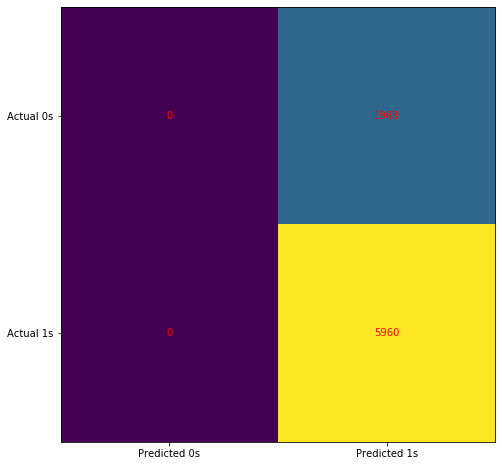

prob  [[0.22040486 0.77959514]
 [0.33326793 0.66673207]
 [0.21666186 0.78333814]
 ...
 [0.21666186 0.78333814]
 [0.15809861 0.84190139]
 [0.31094065 0.68905935]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       569
         1.0       0.76      1.00      0.86      1816

    accuracy                           0.76      2385
   macro avg       0.38      0.50      0.43      2385
weighted avg       0.58      0.76      0.66      2385



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(x)
cm = confusion_matrix(y, y_pred)
print(cm)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

print('prob ',model.predict_proba(X_test))
print(classification_report(y_test, model.predict(X_test)))

In [178]:
print(cm)
print(cm[0][0])

[[323 166]
 [157 347]]
323


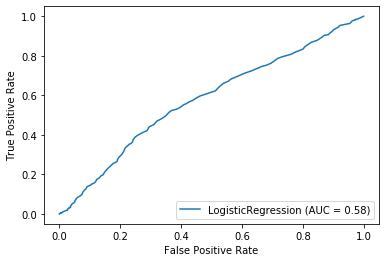

0.7614255765199162


In [22]:
from sklearn.metrics import plot_roc_curve
m_disp = plot_roc_curve(model, X_test, y_test)
plt.show()
from sklearn.metrics import accuracy_score


score =accuracy_score(y_test,y_pred)
print(score)

In [ ]:
'''
Build New metric names with statistic names added

'''
stat_names= ['count','mean','std','min','25pct','50pct','75pct','max',
             'covariance', 'cummax','cummin','cumprod',
             'diff', 'kurtosis','meanavgdev','mode',
             'pctchange','sem','skewness','variance','nunique']
names = list(sub_key_list)
out_names = []
for ii in range(0,len(names)):
    #for each Tina metric, add on the 21 statistic names for them
    tname = names[ii]
    for jj in range(0,21):
        #go through each statistic and add to the name
        temp_name = tname + '_' + stat_names[jj]
        out_names.append(temp_name)

#pdata = pd.DataFrame(output_data)
len(sub_key_list)

114

In [39]:
stype = c_output_data['diagnostics_Image-original_Maximum']
print(len(stype))
print(stype[9])
print(len(stype[0]))

21
[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 253.0, 253.0, 253.0, 253.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 25

In [ ]:
'''
Create Pandas DataFrame from array
'''
pandas_formatted_data = pd.DataFrame(formatted_data).transpose()


with open(pickle_full_statistics_file_dataframe, 'wb') as f:
    pickle.dump(pandas_formatted_data,f)
print('!!!! Pandas output written to pickle file')


pandas_formatted_data.to_csv(csv_full_statistics_file_dataframe)
print('Wrote Pandas DataFrame out to CSV file')


!!!! Pandas output written to pickle file
Wrote Pandas DataFrame out to CSV file


In [ ]:
pandas_formatted_data

,0
mask_num_count,"[44.0, 36.0, 46.0, 38.0, 74.0, 93.0, 90.0, 85...."
mask_num_mean,"[75.43181818181819, 94.05555555555556, 72.0217..."
mask_num_std,"[42.67312085058889, 47.491920783250485, 47.743..."
mask_num_min,"[2.0, 5.0, 0.0, 1.0, 7.0, 5.0, 0.0, 2.0, 0.0, ..."
mask_num_25pct,"[40.5, 54.5, 25.5, 52.5, 121.25, 108.0, 79.0, ..."
...,...
original_ngtdm_Strength_pctchange,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
original_ngtdm_Strength_sem,"[0.21635078227132634, 0.335240914911233, 0.699..."
original_ngtdm_Strength_skewness,"[2.4061963516838096, 2.589311865235689, 5.4639..."
original_ngtdm_Strength_variance,"[2.059537083534254, 4.04591295709874, 22.51589..."


In [ ]:
'''
Get the arrays by column name and put them together into one giant array
'''
field_names = list(total_averages['10009_49280_17920'].keys()) #added list to use pop
if (field_names[0] == 'mask_num'):
    print('Found mask_num, removing')
    field_names.pop(0)
full_array = {}
for ii in range(0,len(field_names)):
    full_array[ii]=[]



for fname in image_name:
    for fcounter,field in enumerate(field_names):
            full_array[fcounter].extend(total_averages[fname][field])

print('Writing Pickle Output')
with open(pickle_output_file, 'wb') as f:
    output_data = [full_array, list(field_names)]
    pickle.dump(output_data, f)

NameError: ignored

In [ ]:
full_array[0][-10]
print(pickle_output_file)

/content/gdrive/My Drive/TILE_PREPROCESSING/PICKLE_FEATURES_AVERAGE_OUTPUT.pck


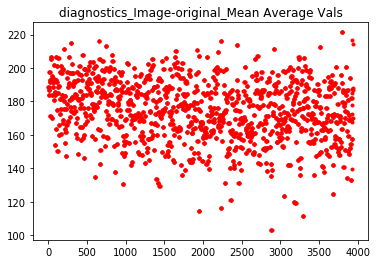

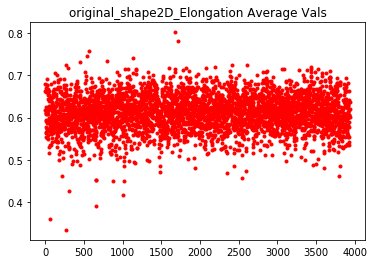

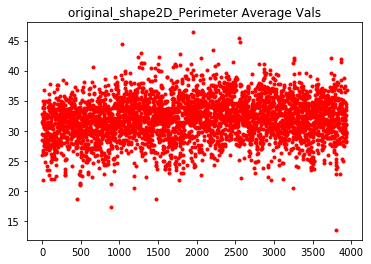

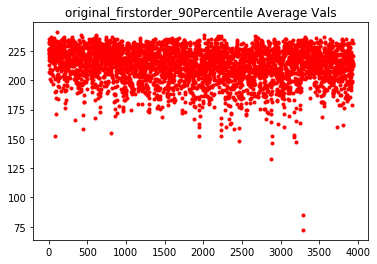

In [ ]:

for ii in range(0,20,5):
    plt.figure()
    plt.plot(full_array[ii],'r.')
    tname = list(field_names)[ii] + ' Average Vals'
    plt.title(tname)


In [ ]:
'''
Make pandas dataframe output ----!!!!! The column names disappear when you save 
it to a pickle file (even with pandas pickle function). No idea what's going on.
'''
cols = list(field_names)
df_full_array = pd.DataFrame(full_array) #list(field_names))
'''
Reformatting DataFrame with fieldnames as columns (instead of the numeric label)
'''

colname = {}
newnames = list(field_names)
print('length of new names is ', len(newnames))
for ii in range(0,len(newnames)):
    colname[ii] = newnames[ii]
df_full_array.rename(columns=colname)

length of new names is  107


,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,...,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,188.462456,8.0,255.0,71.409091,1.000000,0.661786,11.718473,12.061353,70.909091,7.550758,32.701850,0.523623,71.409091,0.887925,145.247727,234.920455,2.690742e+06,2.322153,52.511364,2.632771,249.704545,29.078136,191.064126,192.556818,107.568182,142.136364,21.681773,194.896509,-0.355340,2.690742e+06,0.231896,1349.189074,21.850899,185.894902,-5.217851,6.630234,2.002284,0.475116,1.029103,1.731374,...,0.631587,13.711029,0.085496,10.504044,0.216567,2.281876,21.940622,2.646736,63.421190,0.309043,0.133077,3.281144,29.561276,0.579528,0.716824,0.618423,0.779061,16.582684,0.107310,10.504044,0.216567,2.281876,21.940622,2.646736,63.421190,0.309043,0.133077,29.561276,0.579528,0.779061,16.582684,0.107310,3.281144,0.716824,0.618423,0.518520,0.113649,16.170426,0.094721,1.853209
1,188.462456,8.0,255.0,53.583333,1.000000,0.618440,10.530490,10.864497,53.083333,6.092259,28.532660,0.681450,53.583333,0.865431,136.652778,222.097222,1.851138e+06,2.276597,47.458333,2.396373,240.527778,27.049253,179.770079,180.375000,112.805556,127.722222,19.878789,183.197426,-0.084807,1.851138e+06,0.236088,1163.944755,15.763626,116.405203,-2.191666,5.641938,2.189016,0.369533,1.113850,1.729406,...,0.673328,11.149288,0.119069,8.482303,0.225743,1.988797,16.517839,2.286579,40.0392

In [ ]:
full_array[0][3800:3996]

[42.86666666666667,
 30.2,
 120.32608695652173,
 113.66153846153846,
 121.74324324324324,
 169.21176470588236,
 92.95454545454545,
 137.23333333333332,
 122.02380952380952,
 104.33333333333333,
 43.86666666666667,
 53.696969696969695,
 52.62068965517241,
 58.09090909090909,
 196.27142857142857,
 219.8265306122449,
 185.4967320261438,
 204.26582278481013,
 202.44144144144144,
 189.47674418604652,
 181.61855670103094,
 188.42696629213484,
 137.77215189873417,
 127.02702702702703,
 135.89473684210526,
 132.6315789473684,
 182.28395061728395,
 187.6764705882353,
 219.10638297872342,
 197.3421052631579,
 191.9102564102564,
 176.27472527472528,
 188.348623853211,
 177.64444444444445,
 207.46808510638297,
 189.58474576271186,
 196.16326530612244,
 207.8111111111111,
 176.82407407407408,
 231.75280898876406,
 204.33333333333334,
 190.0204081632653,
 156.67045454545453,
 202.56521739130434,
 155.85849056603774,
 149.5252525252525,
 91.31818181818181,
 101.43181818181819,
 97.08333333333333,
 10

In [ ]:

df_full_array.to_pickle(pickle_output_file_pandas)
df_full_array

#df2 = pd.read_pickle(pickle_output_file_pandas)
#with open(pickle_output_file_pandas, 'wb') as f:
 #   pickle.dump(df_full_array, f)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106
0,188.462456,8.0,255.0,71.409091,1.000000,0.661786,11.718473,12.061353,70.909091,7.550758,32.701850,0.523623,71.409091,0.887925,145.247727,234.920455,2.690742e+06,2.322153,52.511364,2.632771,249.704545,29.078136,191.064126,192.556818,107.568182,142.136364,21.681773,194.896509,-0.355340,2.690742e+06,0.231896,1349.189074,21.850899,185.894902,-5.217851,6.630234,2.002284,0.475116,1.029103,1.731374,...,0.631587,13.711029,0.085496,10.504044,0.216567,2.281876,21.940622,2.646736,63.421190,0.309043,0.133077,3.281144,29.561276,0.579528,0.716824,0.618423,0.779061,16.582684,0.107310,10.504044,0.216567,2.281876,21.940622,2.646736,63.421190,0.309043,0.133077,29.561276,0.579528,0.779061,16.582684,0.107310,3.281144,0.716824,0.618423,0.518520,0.113649,16.170426,0.094721,1.853209
1,188.462456,8.0,255.0,53.583333,1.000000,0.618440,10.530490,10.864497,53.083333,6.092259,28.532660,0.681450,53.583333,0.865431,136.652778,222.097222,1.851138e+06,2.276597,47.458333,2.396373,240.527778,27.049253,179.770079,180.375000,112.805556,127.722222,19.878789,183.197426,-0.084807,1.851138e+06,0.236088,1163.944755,15.763626,116.405203,-2.191666,5.641938,2.189016,0.369533,1.113850,1.729406,...,0.673328,11.149288,0.119069,8.482303,0.225743,1.988797,16.517839,2.286579,40.039287,0.343817,0.175076,3.069529,24.035892,0.616903,0.757143,0.454979,0.802163,13.160797,0.145260,8.482303,0.225743,1.988797,16.517839,2.286579,40.039287,0.343817,0.175076,24.035892,0.616903,0.802163,13.160797,0.145260,3.069529,0.757143,0.454979,0.543260,0.164109,13.286348,0.113516,2.063461
2,188.462456,8.0,255.0,59.173913,1.000000,0.679775,10.571733,10.921777,58.684783,6.699119,29.529445,0.614589,59.173913,0.889636,134.119565,226.523913,2.062704e+06,2.330942,51.527174,2.479429,243.108696,29.560941,182.462453,183.728261,104.391304,138.717391,21.531258,186.627450,-0.274446,2.062704e+06,0.228832,1412.869521,19.828704,169.811329,-5.407021,6.756424,2.304465,0.409493,1.141425,1.744441,...,0.684414,13.924030,0.102471,9.209531,0.212951,2.431542,20.426830,2.191077,45.584765,0.280554,0.143742,3.125727,27.573831,0.627001,0.766741,0.419713,0.810805,16.285528,0.125411,9.209531,0.212951,2.431542,20.426830,2.191077,45.584765,0.280554,0.143742,27.573831,0.627001,0.810805,16.285528,0.125411,3.125727,0.766741,0.419713,0.533919,0.168641,15.300438,0.119669,2.741367
3,188.462456,8.0,255.0,66.000000,1.000000,0.615554,11.593207,11.808502,65.500000,6.847049,31.453089,0.624107,66.000000,0.868820,147.650000,226.834211,2.505867e+06,2.130349,45.026316,2.591744,243.736842,25.548121,189.481151,191.881579,121.947368,121.789474,18.819562,192.682132,-0.269973,2.505867e+06,0.266084,1074.553409,15.464655,120.724420,-4.926934,5.283117,1.613051,0.418150,0.932026,1.598215,...,0.620506,10.101345,0.118301,10.837310,0.248380,1.803229,16.026735,2.630195,43.128859,0.422796,0.187149,3.061608,27.026073,0.565751,0.714349,0.551500,0.759118,12.215935,0.149697,10.837310,0.248380,1.803229,16.026735,2.630195,43.128859,0.422796,0.187149,27.026073,0.565751,0.759118,12.215935,0.149697,3.061608,0.714349,0.551500,0.813637,0.150536,11.090468,0.094188,1.642341
4,186.797775,9.0,255.0,43.094595,1.000000,0.564314,10.025517,10.123883,42.594595,5.076806,25.880480,0.765203,43.094595,0.859680,141.602703,213.367568,1.528729e+06,1.897536,42.023649,2.788171,228.027027,24.158849,179.861341,183.195946,120.932432,107.094595,17.899691,183.364691,-0.247126,1.528729e+06,0.328277,1082.785339,14.228317,178.412986,-6.817306,5.802956,1.317090,0.476519,0.781494,1.396632,...,0.587023,9.228646,0.133626,7.712182,0.293385,1.947120,14.785379,3.200962,43.560140,0.775644,0.237344,2.868333,15.944779,0.539142,0.682893,0.724930,0.725289,11.259047,0.169299,7.712182,0.293385,1.947120,14.785379,3.200962,43.560140,0.775644,0.237344,15.944779,0.539142,0

In [ ]:
df_full_array

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107
0,75.431818,188.462456,8.0,255.0,71.409091,1.000000,0.661786,11.718473,12.061353,70.909091,7.550758,32.701850,0.523623,71.409091,0.887925,145.247727,234.920455,2.690742e+06,2.322153,52.511364,2.632771,249.704545,29.078136,191.064126,192.556818,107.568182,142.136364,21.681773,194.896509,-0.355340,2.690742e+06,0.231896,1349.189074,21.850899,185.894902,-5.217851,6.630234,2.002284,0.475116,1.029103,...,0.631587,13.711029,0.085496,10.504044,0.216567,2.281876,21.940622,2.646736,63.421190,0.309043,0.133077,3.281144,29.561276,0.579528,0.716824,0.618423,0.779061,16.582684,0.107310,10.504044,0.216567,2.281876,21.940622,2.646736,63.421190,0.309043,0.133077,29.561276,0.579528,0.779061,16.582684,0.107310,3.281144,0.716824,0.618423,0.518520,0.113649,16.170426,0.094721,1.853209
1,94.055556,188.462456,8.0,255.0,53.583333,1.000000,0.618440,10.530490,10.864497,53.083333,6.092259,28.532660,0.681450,53.583333,0.865431,136.652778,222.097222,1.851138e+06,2.276597,47.458333,2.396373,240.527778,27.049253,179.770079,180.375000,112.805556,127.722222,19.878789,183.197426,-0.084807,1.851138e+06,0.236088,1163.944755,15.763626,116.405203,-2.191666,5.641938,2.189016,0.369533,1.113850,...,0.673328,11.149288,0.119069,8.482303,0.225743,1.988797,16.517839,2.286579,40.039287,0.343817,0.175076,3.069529,24.035892,0.616903,0.757143,0.454979,0.802163,13.160797,0.145260,8.482303,0.225743,1.988797,16.517839,2.286579,40.039287,0.343817,0.175076,24.035892,0.616903,0.802163,13.160797,0.145260,3.069529,0.757143,0.454979,0.543260,0.164109,13.286348,0.113516,2.063461
2,72.021739,188.462456,8.0,255.0,59.173913,1.000000,0.679775,10.571733,10.921777,58.684783,6.699119,29.529445,0.614589,59.173913,0.889636,134.119565,226.523913,2.062704e+06,2.330942,51.527174,2.479429,243.108696,29.560941,182.462453,183.728261,104.391304,138.717391,21.531258,186.627450,-0.274446,2.062704e+06,0.228832,1412.869521,19.828704,169.811329,-5.407021,6.756424,2.304465,0.409493,1.141425,...,0.684414,13.924030,0.102471,9.209531,0.212951,2.431542,20.426830,2.191077,45.584765,0.280554,0.143742,3.125727,27.573831,0.627001,0.766741,0.419713,0.810805,16.285528,0.125411,9.209531,0.212951,2.431542,20.426830,2.191077,45.584765,0.280554,0.143742,27.573831,0.627001,0.810805,16.285528,0.125411,3.125727,0.766741,0.419713,0.533919,0.168641,15.300438,0.119669,2.741367
3,88.105263,188.462456,8.0,255.0,66.000000,1.000000,0.615554,11.593207,11.808502,65.500000,6.847049,31.453089,0.624107,66.000000,0.868820,147.650000,226.834211,2.505867e+06,2.130349,45.026316,2.591744,243.736842,25.548121,189.481151,191.881579,121.947368,121.789474,18.819562,192.682132,-0.269973,2.505867e+06,0.266084,1074.553409,15.464655,120.724420,-4.926934,5.283117,1.613051,0.418150,0.932026,...,0.620506,10.101345,0.118301,10.837310,0.248380,1.803229,16.026735,2.630195,43.128859,0.422796,0.187149,3.061608,27.026073,0.565751,0.714349,0.551500,0.759118,12.215935,0.149697,10.837310,0.248380,1.803229,16.026735,2.630195,43.128859,0.422796,0.187149,27.026073,0.565751,0.759118,12.215935,0.149697,3.061608,0.714349,0.551500,0.813637,0.150536,11.090468,0.094188,1.642341
4,186.175676,186.797775,9.0,255.0,43.094595,1.000000,0.564314,10.025517,10.123883,42.594595,5.076806,25.880480,0.765203,43.094595,0.859680,141.602703,213.367568,1.528729e+06,1.897536,42.023649,2.788171,228.027027,24.158849,179.861341,183.195946,120.932432,107.094595,17.899691,183.364691,-0.247126,1.528729e+06,0.328277,1082.785339,14.228317,178.412986,-6.817306,5.802956,1.317090,0.476519,0.781494,...,0.587023,9.228646,0.133626,7.712182,0.293385,1.947120,14.785379,3.200962,43.560140,0.775644,0.237344,2.868333,15.944779,0.539142,0.682893,0.724930,0.725289,11.259047,0.169299,7.712182,0.293385,1.947120,14.785379,3.200962,43.560140,0.775644,0.237344,15.944779,0.5

In [ ]:
feature_files[-1]

'11993_30464_18816.csv'